In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sn
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Dropout,Flatten,MaxPooling2D,BatchNormalization
from keras.utils import to_categorical

In [2]:
def merge_history(models):
	data = dict()
	models_copy = models.copy()

	keys = list(models_copy[0].history.keys())
	values = list(models_copy[0].history.values())
	for i in range(len(keys)):
		data[keys[i]] = values[i]
	
	models_copy.pop(0)
	
	for el in models_copy:
		keys = list(el.history.keys())
		values = list(el.history.values())
		for i in range(len(keys)):
			for value in values[i]:
				data[keys[i]].append(value)
	return data

def plot_train_val_data(model,labels,validation=False):
	fig_size_w = len(labels)
 
	if isinstance(model,list):
		istoric = merge_history(model)
		if validation == True:
			val_to_plot = [istoric["val_"+el] for el in labels]
		to_plot = [istoric[el] for el in labels]
	else:
		if validation == True:
			val_to_plot = [model.history["val_"+el] for el in labels]
		to_plot = [model.history[el] for el in labels]

	epochs = range(1, len(to_plot[0]) + 1)

	fig, axes = plt.subplots(1, fig_size_w,figsize=(20, 5))
	fig.tight_layout() 
	for i in range(0, fig_size_w):
		axes[i].plot(epochs, to_plot[i], '-', label=labels[i])
		if(validation == True):
			axes[i].plot(epochs, val_to_plot[i], ':', label="Validation "+labels[i])
		axes[i].set_title(labels[i],fontsize=20)
		axes[i].legend(loc='lower right')

	plt.show()

In [3]:
def get_borders(image,size):
	#STANGA,DREAPTA,SUS,JOS
	for column,i in zip(image.T,range(size)):
		if(np.count_nonzero(column == 0.0)!=size):
			left_border = i
			break
   
	for row,i in zip(image,range(size)):
		if(np.count_nonzero(row == 0.0)!=size):
			upper_border = i
			break

	for column,i in zip(np.flip(image.T),range(size)):
		if(np.count_nonzero(column == 0.0)!=size):
			right_border = i
			break

	for row,i in zip(np.flip(image),range(size)):
		if(np.count_nonzero(row == 0.0)!=size):
			bottom_border = i
			break

	return [left_border,right_border,upper_border,bottom_border]
	
def crop_image(image,upper,lower,left,right,size):
	return np.copy(image[upper:size-lower,left:size-right])

def generate_bordari_sizes(min,max):
    #sus,jos / stanga,dreapta
	sizes = []
	for i in range(min+max+1):
		pair = (i,min+max-i)
		sizes.append(pair)
	return sizes

def pad_with(vector, pad_width, iaxis, kwargs):
	pad_value = kwargs.get('padder', 0)
	vector[:pad_width[0]] = pad_value
	if pad_width[1] != 0:                      # <-- the only change (0 indicates no padding)
		vector[-pad_width[1]:] = pad_value
  
def generate_imagini_bordate(image,output,size):
	imagini_bordate = []
	outputuri_bordate = []
	stanga,dreapta,sus,jos = get_borders(image,size)
	tipuri_bordare1 = generate_bordari_sizes(sus,jos)
	tipuri_bordare2 = generate_bordari_sizes(stanga,dreapta)
	imagine_cropped = crop_image(image,sus,jos,stanga,dreapta,size)	
	for tip1 in tipuri_bordare1:
		for tip2 in tipuri_bordare2:
			imagini_bordate.append(np.pad(imagine_cropped,(tip1, tip2), pad_with, padder=0))
			outputuri_bordate.append(output)
	return imagini_bordate,outputuri_bordate

def generate_imagini_bordate_no_output(image,size):
	imagini_bordate = []
	stanga,dreapta,sus,jos = get_borders(image,size)
	tipuri_bordare1 = generate_bordari_sizes(sus,jos)
	tipuri_bordare2 = generate_bordari_sizes(stanga,dreapta)
	imagine_cropped = crop_image(image,sus,jos,stanga,dreapta,size)	
	for tip1 in tipuri_bordare1:
		for tip2 in tipuri_bordare2:
			imagini_bordate.append(np.pad(imagine_cropped,(tip1, tip2), pad_with, padder=0))
	return imagini_bordate

def plot_bordare_demo(imagine,size):
	stanga,dreapta,sus,jos = get_borders(imagine,size)
	fig_w = sus+jos+1
	fig_h = stanga+dreapta+1
	imagini_bordate = generate_imagini_bordate_no_output(imagine,size)
	fig, axes = plt.subplots(fig_h, fig_w, figsize = (size, fig_h*3))
	fig.tight_layout() 
	for i in range(0, fig_h):
		for j in range(0, fig_w):
			axes[i][j].imshow(np.reshape(imagini_bordate[fig_w * i + j],(size,size)),cmap='gist_gray')
			axes[i][j].set_axis_off()
	plt.show()
 
 
def plot_imagini_demo(imagini,outputuri,size):
	fig_w = 10
	fig_h = 2

	fig, axes = plt.subplots(fig_h, fig_w, figsize = (size, fig_h*3))
	fig.tight_layout() 
	for i in range(0, fig_h):
		for j in range(0, fig_w):
			axes[i][j].imshow(np.reshape(imagini[fig_w * i + j],(size,size)),cmap='gist_gray')#inferno
			axes[i][j].set_title(str(np.argmax(outputuri[fig_w*i+j])),fontsize=40)
			axes[i][j].set_axis_off()     
	plt.show()

In [3]:
date = pd.read_csv("data/train.csv",delimiter=",")

Y = np.array(date[date.columns[0]].tolist())
Y = to_categorical(Y)

date = date.drop(['label'],axis=1)

X = np.array(date.values.tolist())/255.0
X = np.array([np.reshape(el,(28,28)) for el in X])
#X = np.array([np.reshape(el,(28,28,1)) for el in X])

train_X, test_X, train_Y, test_Y = train_test_split(X, Y, train_size=35000,shuffle=True)

del date
del X
del Y

#plot_imagini_demo(train_X,train_Y,28)

In [9]:
test_X.shape

(7000, 28, 28)

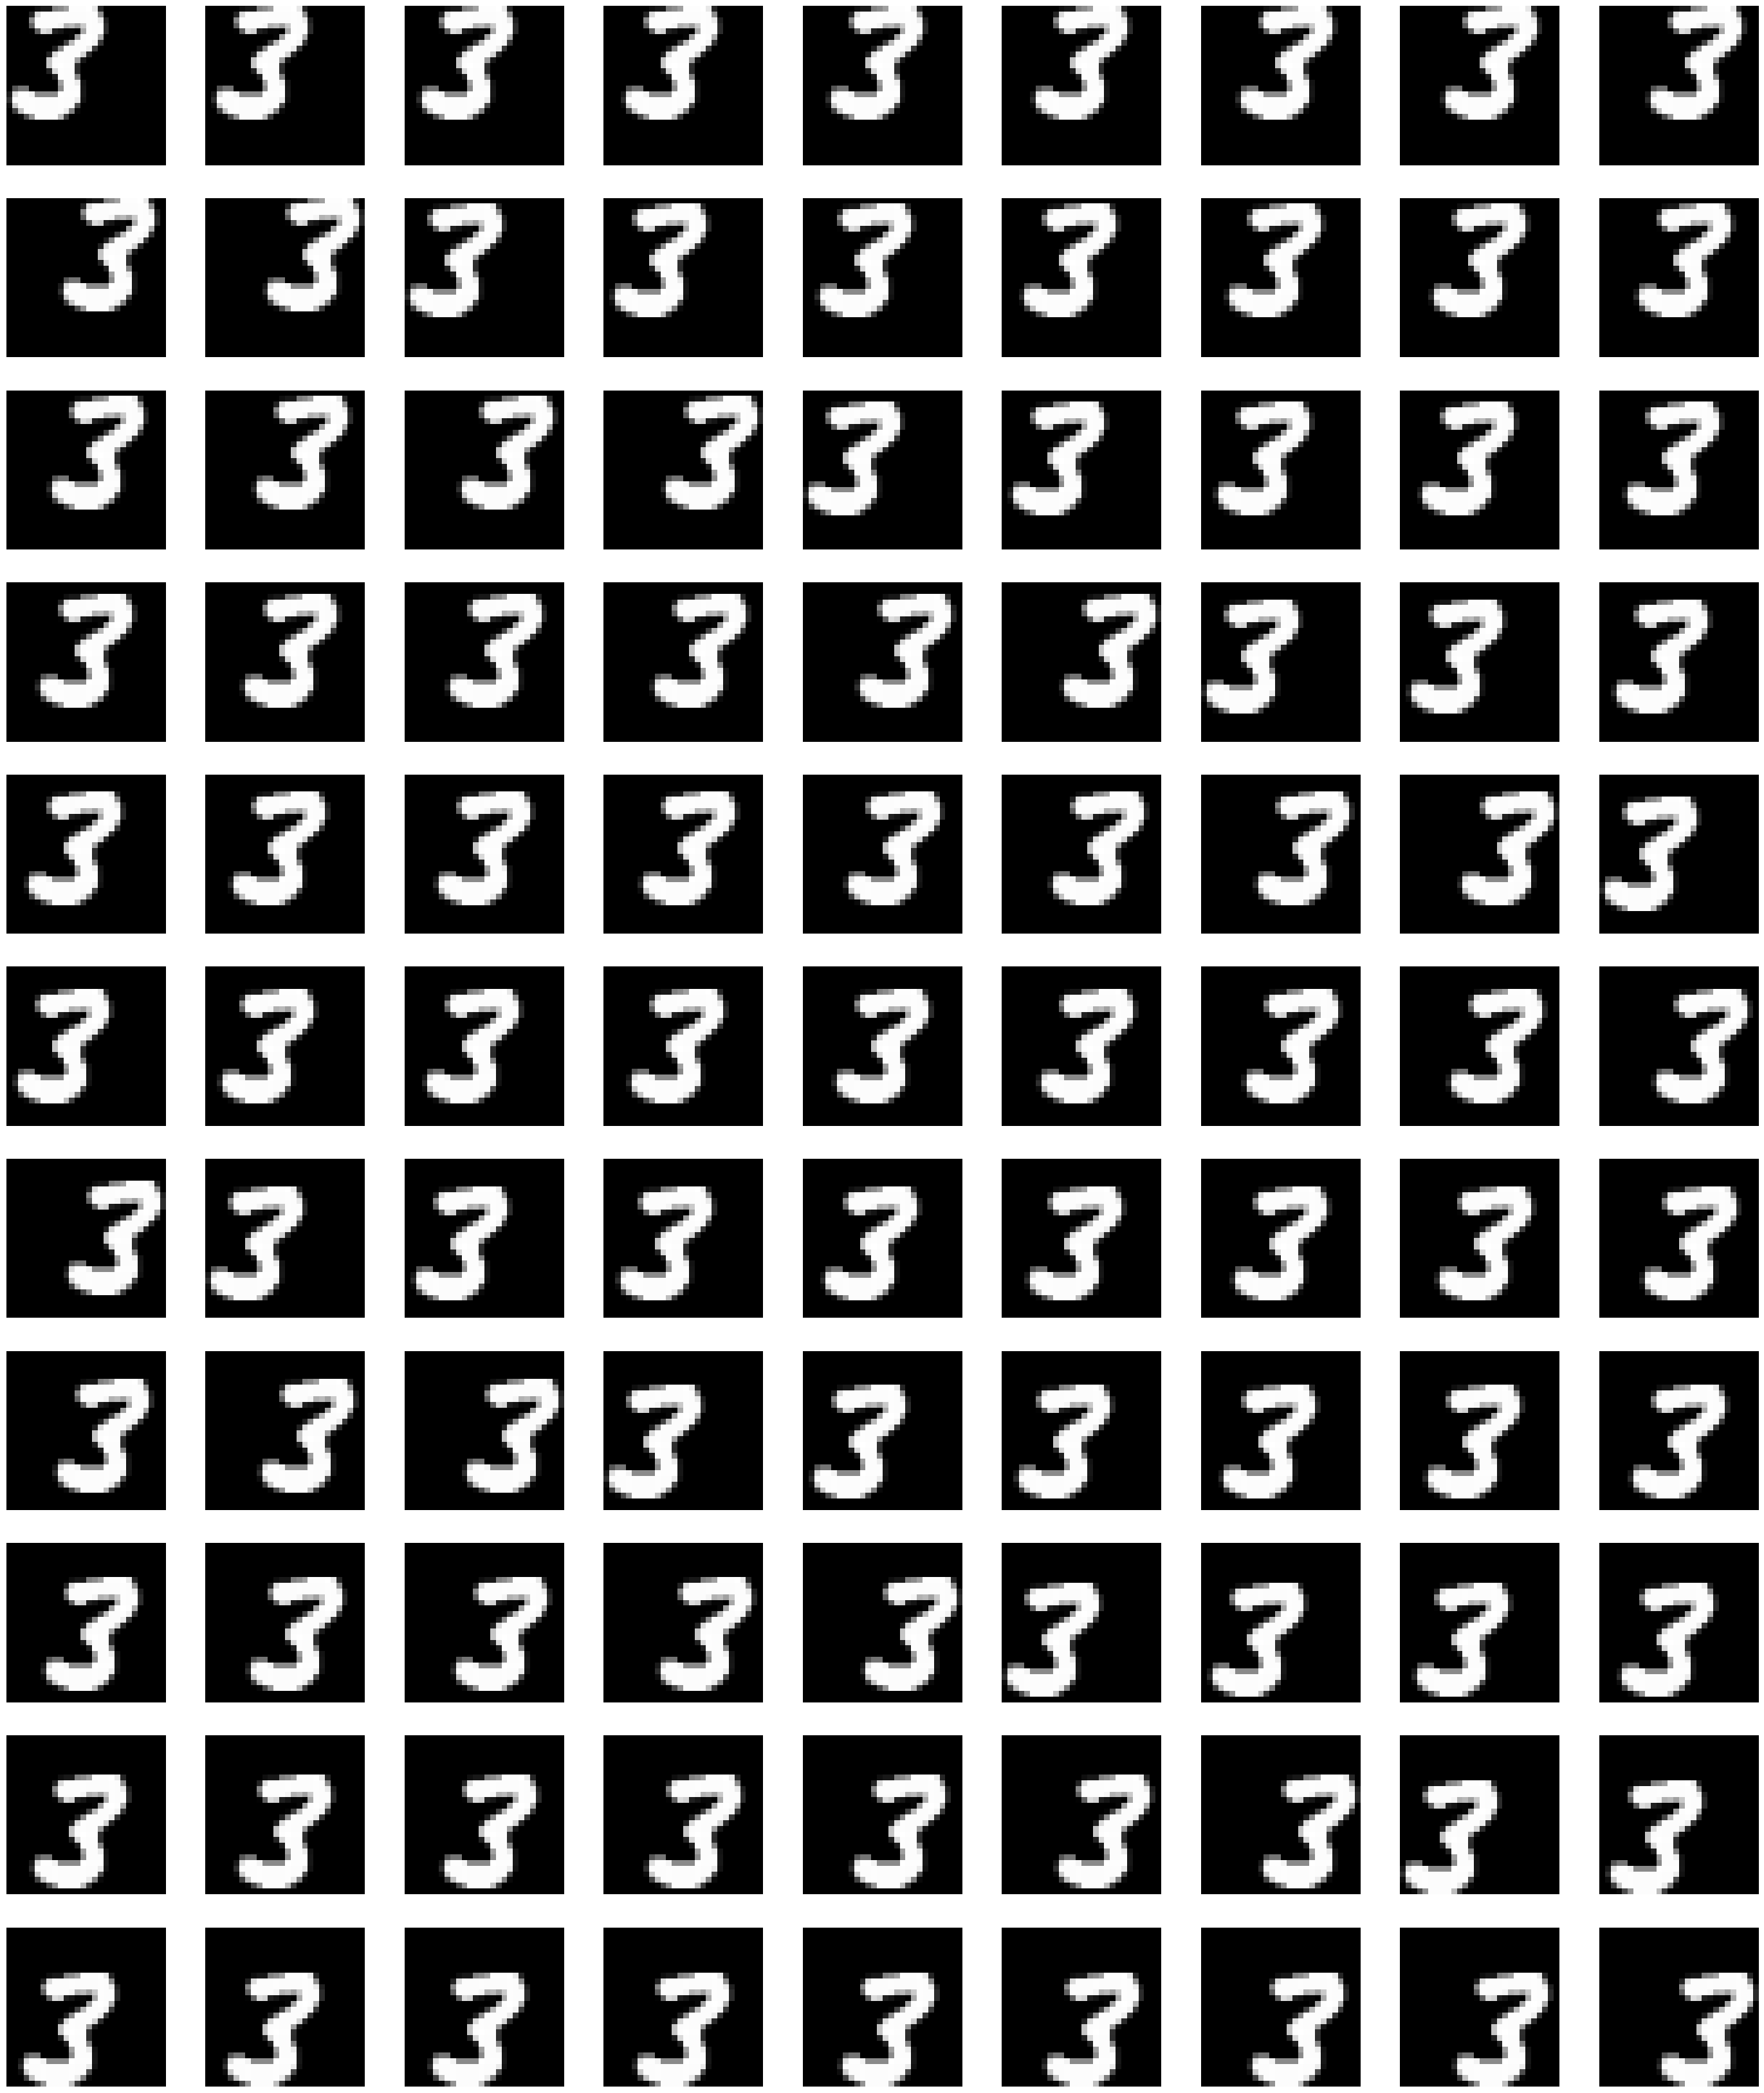

In [5]:
plot_bordare_demo(train_X[0],28)

In [6]:
def trainer(model,imagini,outputuri,size):
	hist=[]
	stepsize = 250
	print(int(len(imagini)/stepsize))
	for index in range(int(len(imagini)/stepsize)):
		print(index)
		imagini_bordate = []
		outputuri_bordate= []
		for imagine,output in zip(imagini[index*stepsize:index*stepsize+stepsize],outputuri[index*stepsize:index*stepsize+stepsize]):
			imagine_bordata,output_bordat = generate_imagini_bordate(imagine,output,size)		
			imagini_bordate.extend(imagine_bordata)
			outputuri_bordate.extend(output_bordat)
		imagini_bordate = np.array(imagini_bordate)
		outputuri_bordate = np.array(outputuri_bordate)
  
		X_train, X_test, Y_train, Y_test = train_test_split(imagini_bordate, outputuri_bordate, train_size=0.85,shuffle=True)
		ist = model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=2)
		hist.append(ist)
		del imagini_bordate
		del outputuri_bordate
	return hist

In [7]:
METRICS = [
	tf.keras.metrics.BinaryAccuracy(name="accuracy"),
	tf.keras.metrics.Precision(name='precision'),
	tf.keras.metrics.Recall(name='recall')
]
model = Sequential()

model.add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=3, strides=2,padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.50))

model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.50))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.50))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer = tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=METRICS)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 32)        9248      
                                                                 
 batch_normalization_2 (Batc  (None, 12, 12, 32)       1

In [8]:
#tf.config.run_functions_eagerly(True)

In [ ]:
hist = trainer(model,train_X,train_Y,size=28)

In [ ]:
plot_train_val_data(hist,["loss","accuracy","precision","recall"],True)

In [ ]:
predicted = model.predict(test_X)
predicted = [np.argmax(el) for el in predicted]
actual = [np.argmax(el) for el in test_Y]

print("Accuracy: ",accuracy_score(actual,predicted))
print("Precision: ",precision_score(actual,predicted,average="macro"))
print("Recall: ",recall_score(actual,predicted,average="macro"))
print("F1 Score: ",f1_score(actual,predicted,average="macro"))

cm = confusion_matrix(actual, predicted)
sn.heatmap(cm, annot=True, fmt='d',cmap="inferno")
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [ ]:

date_test = pd.read_csv("data/test.csv",delimiter=",")
test_X = np.array(date_test.values.tolist())/255.0
test_X = np.array([np.reshape(el,(28,28)) for el in test_X])

y_predicted = model.predict(test_X)
predicted = [np.argmax(el) for el in y_predicted]

results = pd.Series(predicted,name='Label')
submission = pd.concat([pd.Series(range(1,28001),name="ImageId"),results],axis=1)
submission.to_csv("output.csv",index=False)
